In [1]:
import os, glob, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbCallback
import gc

# Decorador para que Hugging Face/Keras reconozcan la función
@tf.keras.utils.register_keras_serializable()
def calc_mvd(real_images, gen_images):
    """
    Calcula la distancia entre medias y desviaciones estándar (Mean-Variance Distance)
    entre un conjunto de imágenes reales y otro de imágenes generadas.
    """
    real_flat = real_images.reshape(real_images.shape[0], -1)
    gen_flat = gen_images.reshape(gen_images.shape[0], -1)
    mean_real = np.mean(real_flat, axis=0)
    std_real = np.std(real_flat, axis=0)
    mean_gen = np.mean(gen_flat, axis=0)
    std_gen = np.std(gen_flat, axis=0)
    mean_distance = np.linalg.norm(mean_real - mean_gen)
    std_distance = np.linalg.norm(std_real - std_gen)
    return mean_distance + std_distance

# Callback para loguear MVD al final de cada época
class MVDEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, real_data, decoder, latent_dim, label_prefix="Train"):
        super().__init__()
        self.real_data = real_data
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.label_prefix = label_prefix

    def on_epoch_end(self, epoch, logs=None):
        # Generar muestras aleatorias en el espacio latente
        z_samples = np.random.normal(size=(len(self.real_data), self.latent_dim))
        gen_images = self.decoder.predict(z_samples)
        # Calcular MVD entre las imágenes reales y generadas
        mvd_value = calc_mvd(self.real_data, gen_images)
        # Loguear en W&B
        wandb.log({f"MVD_{self.label_prefix}": mvd_value, "epoch": epoch})


In [2]:
# Rutas base
base_path = "/content/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset"
train_path = os.path.join(base_path, "train")
val_path   = os.path.join(base_path, "val")
test_path  = os.path.join(base_path, "test")

# Obtener las rutas de las imágenes para cada categoría
train_paths_botellas = glob.glob(train_path + "/botella_de_vidrio/*.npy")
train_paths_relojes  = glob.glob(train_path + "/reloj_de_pared_circular_clasico/*.npy")

val_paths_botellas   = glob.glob(val_path + "/botella_de_vidrio/*.npy")
val_paths_relojes    = glob.glob(val_path + "/reloj_de_pared_circular_clasico/*.npy")

test_paths_botellas  = glob.glob(test_path + "/botella_de_vidrio/*.npy")
test_paths_relojes   = glob.glob(test_path + "/reloj_de_pared_circular_clasico/*.npy")

# Cargar las imágenes para cada categoría
X_train_botellas = np.array([np.load(p) for p in train_paths_botellas])
X_train_relojes  = np.array([np.load(p) for p in train_paths_relojes])

X_val_botellas   = np.array([np.load(p) for p in val_paths_botellas])
X_val_relojes    = np.array([np.load(p) for p in val_paths_relojes])

X_test_botellas  = np.array([np.load(p) for p in test_paths_botellas])
X_test_relojes   = np.array([np.load(p) for p in test_paths_relojes])

In [3]:
print("Botellas - Train:", X_train_botellas.shape, "Val:", X_val_botellas.shape, "Test:", X_test_botellas.shape)
print("Relojes - Train:", X_train_relojes.shape, "Val:", X_val_relojes.shape, "Test:", X_test_relojes.shape)

Botellas - Train: (45, 256, 256, 3) Val: (10, 256, 256, 3) Test: (10, 256, 256, 3)
Relojes - Train: (45, 256, 256, 3) Val: (10, 256, 256, 3) Test: (10, 256, 256, 3)


In [4]:
# Semilla para reproducibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Definir tamaño de imagen
IMG_SIZE = 256  # Ajusta según tu dataset

In [5]:
from tensorflow.keras import layers, Model, Input
import tensorflow.keras.backend as K

class VAE(Model):
    def __init__(self, encoder, decoder, img_size=IMG_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.img_size = img_size
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def vae_loss(self, y_true, y_pred, z_mean, z_log_var):
        reconstruction_loss = tf.keras.losses.mse(K.flatten(y_true), K.flatten(y_pred))
        reconstruction_loss *= self.img_size * self.img_size * 3
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = -0.5 * tf.reduce_mean(kl_loss)
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            loss = self.vae_loss(data, reconstruction, z_mean, z_log_var)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        # Aquí, para no sobreescribir kl_loss, podrías calcularlo aparte si lo quisieras exacto.
        # Pero en este ejemplo, se actualiza la reconstrucción y KL por separado de forma aproximada.
        # Lo importante es que en logs se vea la métrica final.
        recon_loss_value = reconstruction_loss = tf.keras.losses.mse(
            K.flatten(data), K.flatten(reconstruction)
        ) * (self.img_size * self.img_size * 3)
        kl_value = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_value = -0.5 * tf.reduce_mean(kl_value)

        self.reconstruction_loss_tracker.update_state(recon_loss_value)
        self.kl_loss_tracker.update_state(kl_value)

        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z = self.encoder(inputs)[2]
        reconstructed = self.decoder(z)
        return reconstructed

def build_vae(latent_dim, img_size=IMG_SIZE):
    # --- Encoder ---
    encoder_inputs = Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean), seed=42)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # --- Decoder ---
    latent_inputs = Input(shape=(latent_dim,))
    x = layers.Dense((img_size // 16) * (img_size // 16) * 256, activation='relu')(latent_inputs)
    x = layers.Reshape((img_size // 16, img_size // 16, 256))(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    decoder_outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, decoder_outputs, name="decoder")
    vae = VAE(encoder, decoder, img_size=img_size)
    return vae, encoder, decoder

In [6]:
# Instanciar y compilar los VAEs para cada clase
LATENT_DIM = 256

# VAE para Botellas
vae_bottle, encoder_bottle, decoder_bottle = build_vae(LATENT_DIM, img_size=IMG_SIZE)
optimizer_bottle = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae_bottle.compile(optimizer=optimizer_bottle, loss=tf.keras.losses.mse)

# VAE para Relojes
vae_clock, encoder_clock, decoder_clock = build_vae(LATENT_DIM, img_size=IMG_SIZE)
optimizer_clock = tf.keras.optimizers.Adam(learning_rate=1e-4)
vae_clock.compile(optimizer=optimizer_clock, loss=tf.keras.losses.mse)

vae_bottle.summary()
vae_clock.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 256), (None, 256),  │      68,025,024 │
│                                      │ (None, 256))                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 256, 256, 3)         │      17,822,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,847,939 (327.48 MB)

 Trainable params: 85,846,019 (327.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 256), (None, 256),  │      68,025,024 │
│                                      │ (None, 256))                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 256, 256, 3)         │      17,822,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,847,939 (327.48 MB)

 Trainable params: 85,846,019 (327.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [7]:
# Login a wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pablo-blanco (arturo-torres-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
# Definir ruta donde se guardarán los modelos
models_path = "/content/Deep_learning/Proyecto 1 - DAE + VAE/Models"
os.makedirs(models_path, exist_ok=True)

In [9]:
# Entrenamiento VAE Botellas
run_bottle = wandb.init(entity="arturo-torres-iteso", project="VAE + DAE", name="VAE_bottles_Arturo", reinit=True)

history_bottle = vae_bottle.fit(
    X_train_botellas,
    X_train_botellas,
    epochs=450,
    batch_size=4,
    validation_data=(X_val_botellas, X_val_botellas),
    callbacks=[
        WandbCallback(save_model=False),
        MVDEpochCallback(X_train_botellas, decoder_bottle, LATENT_DIM, label_prefix="Bottles")
    ]
)

# Definir ruta completa para guardar el modelo de botellas
model_save_path_bottle = os.path.join(models_path, "vae_bottle_model_Arturo.keras")
vae_bottle.save(model_save_path_bottle)
wandb.save(model_save_path_bottle)
wandb.finish()

# Liberar memoria
tf.keras.backend.clear_session()
gc.collect()

# Entrenamiento VAE Relojes
run_clock = wandb.init(project="VAE + DAE", name="VAE_Clock_Arturo", reinit=True)

history_clock = vae_clock.fit(
    X_train_relojes,
    X_train_relojes,
    epochs=450,
    batch_size=4,
    validation_data=(X_val_relojes, X_val_relojes),
    callbacks=[
        WandbCallback(save_model=False),
        MVDEpochCallback(X_train_relojes, decoder_clock, LATENT_DIM, label_prefix="Clocks")
    ]
)

# Definir ruta completa para guardar el modelo de relojes
model_save_path_clock = os.path.join(models_path, "vae_clock_model_Arturo.keras")
vae_clock.save(model_save_path_clock)
wandb.save(model_save_path_clock)
wandb.finish()

tf.keras.backend.clear_session()

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - kl_loss: 10018849.0000 - loss: 10044141.0000 - reconstruction_loss: 25291.7969 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - kl_loss: 0.1588 - loss: 11926.5469 - reconstruction_loss: 11926.3877 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - kl_loss: 0.6735 - loss: 13922.5381 - reconstruction_loss: 13921.8652 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - kl_loss: 0.7405 - loss: 8786.8555 - reconstruction_loss: 8786.1152 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epo

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


MVD_Bottles,▆▅█▇▇▇▇▇▇▇▇▅▅▆▆▆▅▅▃▃▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
kl_loss,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃█▄▄▇▃▃▃▃▃▃
loss,▇▅▅▅▅▅▄▄▄▄▇▅█▄▄▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▃▃▂▁▁▁▁▁
reconstruction_loss,█▇▆▃▃▃▂▂▃▄▂▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁
val_kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MVD_Bottles,144.38878
epoch,449
kl_loss,4.52812


Epoch 1/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 700ms/step - kl_loss: 70.8263 - loss: 28616.7656 - reconstruction_loss: 28545.9395 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - kl_loss: 519.7412 - loss: 25122.1719 - reconstruction_loss: 24602.4316 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - kl_loss: 1035.6747 - loss: 16759.7617 - reconstruction_loss: 15724.0859 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - kl_loss: 121.4956 - loss: 12167.7373 - reconstruction_loss: 12046.2422 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+

MVD_Clocks,▄▃▃▁▁▁▂▂▁▂▄▅▂▄▁▄▃▅▄▅▆▄▇▆▆▅▅█▇▇▇▆▆▇▇██▅▇█
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
kl_loss,██▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
loss,█▇▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,██▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁
val_kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MVD_Clocks,268.38019
epoch,449
kl_loss,13.7171


In [10]:
# Ejemplo de evaluación posterior con la métrica MVD en test
run_eval = wandb.init(project="VAE + DAE", name="Evaluation_MVD", reinit=True)

def evaluate_mvd(decoder, real_data, latent_dim, label_prefix):
    n_samples = len(real_data)
    z_samples = np.random.normal(size=(n_samples, latent_dim))
    gen_images = decoder.predict(z_samples)
    mvd_val = calc_mvd(real_data, gen_images)
    print(f"{label_prefix} VAE - MVD: {mvd_val:.2f}")
    wandb.log({f"MVD_{label_prefix}_test": mvd_val})

# Cargamos los modelos (si fuera un nuevo entorno, harías load_model con custom_objects)
# vae_bottle_loaded = tf.keras.models.load_model("vae_bottle_model_Arturo.keras", custom_objects={"calc_mvd": calc_mvd, "VAE": VAE})
# O en el mismo notebook simplemente reusas "decoder_bottle".

# Evaluación en test
evaluate_mvd(decoder_bottle, X_test_botellas, LATENT_DIM, "Bottle")
evaluate_mvd(decoder_clock, X_test_relojes, LATENT_DIM, "Clock")

wandb.finish()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
Bottle VAE - MVD: 147.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Clock VAE - MVD: 231.14


MVD_Bottle_test,▁
MVD_Clock_test,▁
MVD_Bottle_test,147.54382
MVD_Clock_test,231.142


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


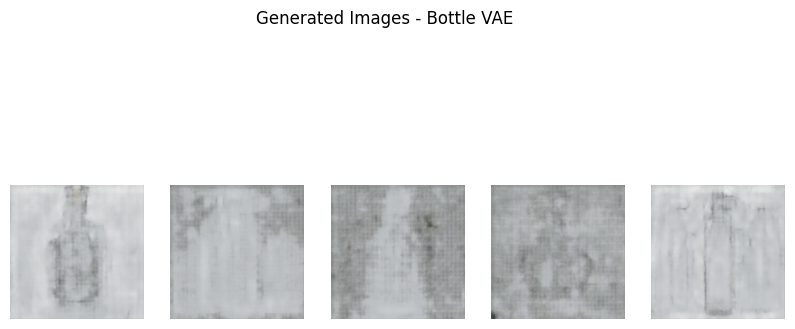

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


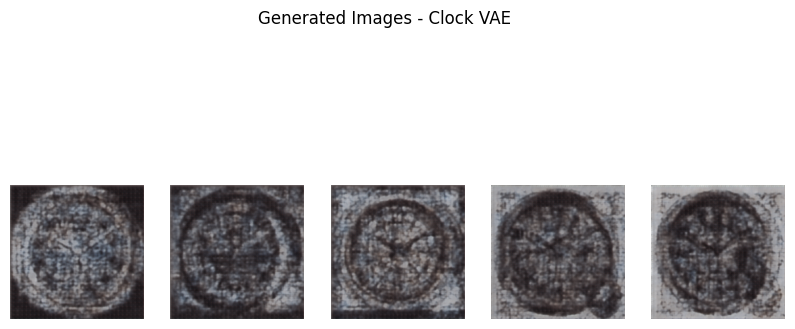

In [11]:
# Visualización de algunas imágenes generadas
def display_generated_images(gen_images, title):
    plt.figure(figsize=(10, 5))
    n = min(5, gen_images.shape[0])
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(gen_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Generar imágenes con el decoder de botellas
z_samples_bottle = np.random.normal(size=(5, LATENT_DIM))
gen_images_bottle = decoder_bottle.predict(z_samples_bottle)
display_generated_images(gen_images_bottle, "Generated Images - Bottle VAE")

# Generar imágenes con el decoder de relojes
z_samples_clock = np.random.normal(size=(5, LATENT_DIM))
gen_images_clock = decoder_clock.predict(z_samples_clock)
display_generated_images(gen_images_clock, "Generated Images - Clock VAE")

# Log en W&B
run_vis = wandb.init(project="VAE + DAE", name="Generated_Images", reinit=True)
wandb.log({
    "Generated_Images_Bottle": [wandb.Image(img) for img in gen_images_bottle[:5]],
    "Generated_Images_Clock": [wandb.Image(img) for img in gen_images_clock[:5]]
})
wandb.finish()

In [12]:
from huggingface_hub import HfApi

api = HfApi()

In [14]:
from huggingface_hub import notebook_login
notebook_login()

# Subir el modelo DAE
api.upload_file(
    path_or_fileobj="/content/Deep_learning/Proyecto 1 - DAE + VAE/Models/dae_model.keras",
    path_in_repo="dae_model.keras",
    repo_id="Ju4nPa2009/VAE_DAE",
    repo_type="model",
)

# Subir el modelo VAE para botellas
api.upload_file(
    path_or_fileobj="/content/Deep_learning/Proyecto 1 - DAE + VAE/Models/vae_bottle_model_Arturo.keras",
    path_in_repo="vae_bottle_model_Arturo.keras",
    repo_id="Ju4nPa2009/VAE_DAE",
    repo_type="model",
)

# Subir el modelo VAE para relojes
api.upload_file(
    path_or_fileobj="/content/Deep_learning/Proyecto 1 - DAE + VAE/Models/vae_clock_model_Arturo.keras",
    path_in_repo="vae_clock_model_Arturo.keras",
    repo_id="Ju4nPa2009/VAE_DAE",
    repo_type="model",
)

vae_bottle_model_Arturo.keras:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

vae_clock_model_Arturo.keras:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Ju4nPa2009/VAE_DAE/commit/00ac75a9632ae18c0d67dd49c2cac3b68164bad8', commit_message='Upload vae_clock_model_Arturo.keras with huggingface_hub', commit_description='', oid='00ac75a9632ae18c0d67dd49c2cac3b68164bad8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Ju4nPa2009/VAE_DAE', endpoint='https://huggingface.co', repo_type='model', repo_id='Ju4nPa2009/VAE_DAE'), pr_revision=None, pr_num=None)